In [1]:
include("./src/gravity-tools.jl")
include("./src/trade-environment.jl")
using CSV
using DataFrames
using Plots
using MINPACK

## Step 1 Bulid the Eaton and Kortum (2002) dataset

Honestly, this came from my MATLAB code as a PHD student. The issue now is the Econometrica replication files are in GAUSS...

In [2]:
################################################################
# builds the EK dataset

dftrade = DataFrame(CSV.File("./ek-data/ek-data.csv"))

dflang = DataFrame(CSV.File("./ek-data/ek-language.csv"))

dflabor = DataFrame(CSV.File("./ek-data/ek-labor.csv"))

filter!(row -> ~(row.trade ≈ 1.0), dftrade);

filter!(row -> ~(row.trade ≈ 0.0), dftrade);

dftrade = hcat(dftrade, dflang);

#dfcntryfix = select(dftrade,Not("trade"))
dfcntryfix = DataFrame(CSV.File("./ek-data/ek-cntryfix.csv"));

## Step 2

This runs the "Gravity Regression" (equation (28)) with the trade cost specification in equation (29). 

The function ``gravity`` runs a Fixed Effect Model (using that package in Julia) and then normalizes the coefficients per Eaton and Kortum's normalization (see footnote of Table III). 

The output ``grvdata`` is a structure with the estimated coefficients.

In [3]:
grvdata = gravity(dftrade, display = true);


                            Fixed Effect Model                            
Number of obs:                   342  Degrees of freedom:                8
R2:                            0.976  R2 Adjusted:                   0.972
F-Stat:                      87.9716  p-value:                       0.000
R2 within:                     0.729  Iterations:                        4
trade          |  Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
--------------------------------------------------------------------------
bin375         |   3.45649  0.204755  16.8811    0.000   3.05353   3.85946
bin750         |   2.89299  0.167308  17.2914    0.000   2.56372   3.22226
bin1500        |   2.52554  0.156294  16.1589    0.000   2.21795   2.83313
bin3000        |   2.34086   0.20072  11.6623    0.000   1.94583   2.73588
bin6000        |  0.494561  0.121258  4.07857    0.000   0.25592  0.733202
binmax         |       0.0       NaN      NaN      NaN       NaN       NaN
border         |  0.30356

## Step 3

This next step recovers the primitives from the gravity coeffecients. Each function does what it says...gets the trade costs, gets the technology term. And all this is given a $\theta$. 

In [4]:
# ################################################################
# # Recover the trade costs and technology parameters

θ = 4.0

d = zeros(19,19)
T = zeros(19)
W = ones(19)

make_trade_costs!(dfcntryfix, grvdata, d, θ)

make_technology!(grvdata, T, W, θ)

## Step 4

Here I construct the pattern of trade (the $\pi$'s) given the primitives. Then I test if I run the gravity regression on the model generated data, do I get back what I fed into it. I do.

In [5]:
@time πshares, Φ = eaton_kortum(W, d, T, θ)

# Now re-run the gravity regression on the model to 
# see if we recover the proper coeffecients

trademodel = log.(vec(normalize_by_home_trade(πshares)'))

dfmodel = DataFrame(trade = trademodel)

filter!(row -> ~(row.trade ≈ 1.0), dfmodel);

filter!(row -> ~(row.trade ≈ 0.0), dfmodel);

dfmodel = hcat(dfmodel, dfcntryfix)

grv = gravity(dfmodel, display = true);

  0.110086 seconds (201.64 k allocations: 10.259 MiB, 99.94% compilation time)
                              Fixed Effect Model                              
Number of obs:                     342  Degrees of freedom:                  8
R2:                              1.000  R2 Adjusted:                     1.000
F-Stat:                     2.38088e30  p-value:                         0.000
R2 within:                       1.000  Iterations:                          4
trade          |  Estimate   Std.Error    t value Pr(>|t|) Lower 95% Upper 95%
------------------------------------------------------------------------------
bin375         |   3.45649 1.30621e-15  2.6462e15    0.000   3.45649   3.45649
bin750         |   2.89299 1.06732e-15 2.71051e15    0.000   2.89299   2.89299
bin1500        |   2.52554 9.97059e-16 2.53299e15    0.000   2.52554   2.52554
bin3000        |   2.34086 1.28047e-15 1.82812e15    0.000   2.34086   2.34086
bin6000        |  0.494561 7.73554e-16 6.39336e14   

## Step 5

Let's visualize the model's prediction against the data.

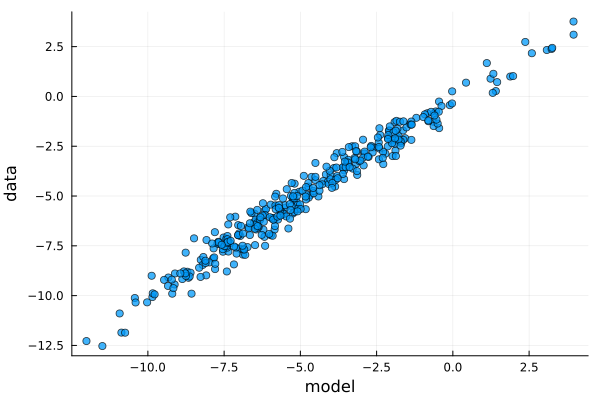

In [6]:
plot(dfmodel.trade, dftrade.trade, seriestype = :scatter, alpha = 0.75,
    xlabel = "model",
    ylabel = "data",
    legend = false)